   # Heart Health Machine Learning Classifier

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


[Data Dictionary](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data)

In [2]:
# Take in the data into a data frame
df = pd.read_csv("cardio_train.csv", delimiter=";").drop(columns=["id"])
df.drop_duplicates(inplace=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## EDA

In [3]:
# See the types of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69976 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int64  
 1   gender       69976 non-null  int64  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [4]:
for col in df.columns:
    print(col, "\n", df[col].unique(), "\n")

age 
 [18393 20228 18857 ... 14925 17727 17926] 

gender 
 [2 1] 

height 
 [168 156 165 169 151 157 178 158 164 173 181 172 170 154 162 163 153 159
 166 155 160 175 171 152 187 148 179 180 188 185 167 183 174 176 161 184
 177 182  76 149 142 150 144 147 186 146 141 195 140 198 145 143 196 138
 194 190 134 136 100 120 189 137 192 122 250 191 117  70  97 119 130 110
 193  75 132  71 135  67 125 139 133  74  98 112 207  68  55  81  80  64
  91  60 109  72 197  65 128 105 108 200 104 111 113  96 131  59  66  99
  57] 

weight 
 [ 62.    85.    64.    82.    56.    67.    93.    95.    71.    68.
  80.    60.    78.   112.    75.    52.    83.    69.    90.    45.
  65.    59.    66.    74.   105.    73.    55.    70.    72.    63.
  50.   107.    84.    77.    79.    76.    58.   115.    97.    53.
  57.    49.   110.    94.    92.    87.   103.    88.    99.   100.
  61.    48.    54.    51.    47.    91.   104.    81.    98.   108.
  89.   101.    86.    65.5  142.    96.    44.    41. 

While a few of the binary variables are encoded as numbers, most of them are already 0 or 1, which is good for our model. We may want to change gender to be 0=Female, 1=Male

In [5]:
# Make 0=Female, 1=Male
df['gender'] = df['gender'].apply(lambda x: x - 1)
print(df['gender'].unique())

[1 0]


In [6]:
# Let's add a bmi column since that is sometimes important in assessing health 
df["bmi"] = df["weight"] / (df["height"]/100)**2

# Make sure to remove any weird values
out_filter = ((df["ap_hi"]>250) | (df["ap_lo"]>200))
out_filter2 = ((df["ap_hi"] < 0) | (df["ap_lo"] < 0))
df = df[~out_filter]
df = df[~out_filter2]

# Print updated length of data
len(df)

/var/folders/7_/cvwl85wx2fl6nqllfxthwnsm0000gn/T/ipykernel_57818/2100621977.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~out_filter2]


68975

### Define a distribution function

In [7]:
def plot_dist(col, name):
    sns.set(style="whitegrid")  # Set the style for the plot

    # Create the distribution plot
    sns.histplot(df[col], kde=True, color='skyblue')

    # Set plot labels and title
    plt.xlabel(name + "s")
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + name)

    # Show the plot
    plt.show()

### Plot the distribution of weight

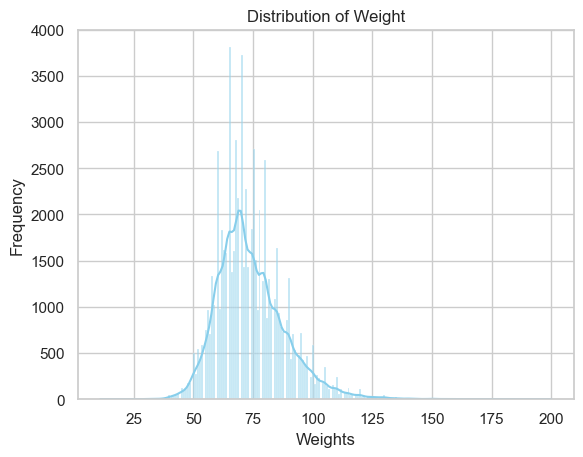

In [8]:
plot_dist("weight", "Weight")

### Plot the distribution of age (in years)

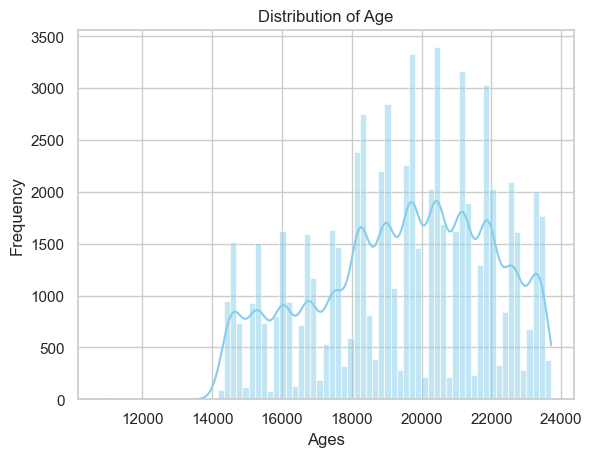

In [9]:
plot_dist("age", "Age")

The age distribution looks pretty nasty, maybe we can round to the nearest year?

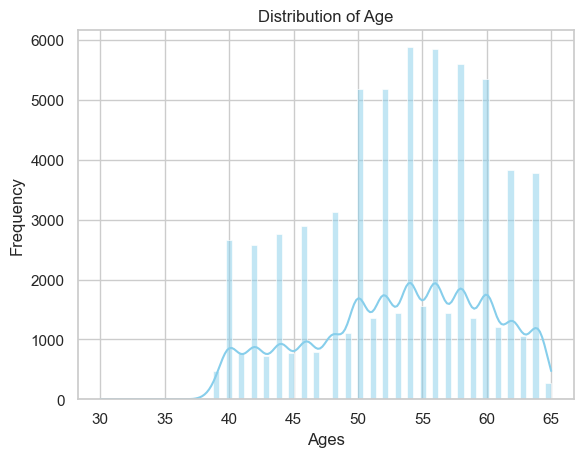

In [10]:
def round_days_to_nearest_year(days):
    # Convert days to years
    years = days / 365.25  # Accounting for leap years

    # Round to the nearest year
    rounded_years = round(years)

    return int(rounded_years)

# Map the age in days to years
df["age"] = df["age"].apply(round_days_to_nearest_year)

# Plot the new distribution
plot_dist("age", "Age")

## Model Creation

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [12]:
numerical_features = [
    "age",
    "height",
    "weight",
    "ap_hi",
    "ap_lo",
    "bmi"
]

categorical_features = [
    "gender",
    "cholesterol",
    "gluc",
    "smoke",
    "alco",
    "active",
]

features = numerical_features + categorical_features

target = "cardio"

In [13]:
# Split the features into test and train datasets

# input features (X) and target (y)
X = df[features]
y = df[target]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y
                                                   )

### k-NN Algorithm

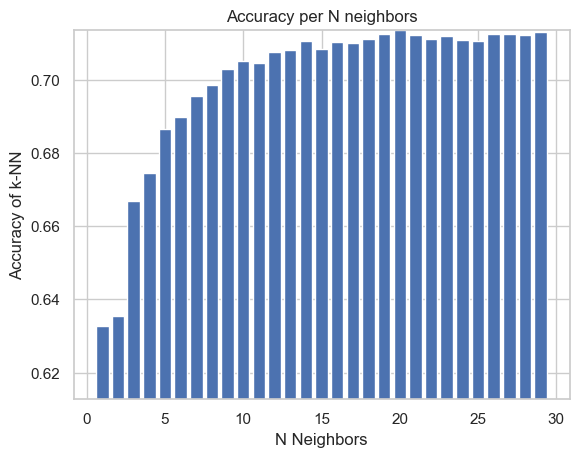

In [14]:
# Hyper Parameter Tuning (Different n_neighbors)
n_range = list(range(1, 30))
accuracy = []
for n in n_range:
    # Instantiate the Model
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    accuracy.append(knn.score(X_test, y_test))
    
# Create a visualization
fig, ax = plt.subplots()

ax.bar(n_range, accuracy)
ax.set_xlabel("N Neighbors")
ax.set_ylabel("Accuracy of k-NN")
ax.set_title("Accuracy per N neighbors")
plt.ylim(min(accuracy) - 0.02, max(accuracy))

plt.show()

### Random Forest Algorithm

In [15]:
# Model Creation
for n in range(100, 210, 20):
    rf = RandomForestClassifier(n_estimators=n,
                                random_state=42)
    rf.fit(X_train, y_train)
    # Make predictions for the test set
    y_pred_test = rf.predict(X_test)
    # View accuracy score
    print(f'{n}: Accuracy: {round(accuracy_score(y_test, y_pred_test), 4)}')

100: Accuracy: 0.7082
120: Accuracy: 0.7076
140: Accuracy: 0.7074
160: Accuracy: 0.7091
180: Accuracy: 0.7082
200: Accuracy: 0.7088


### Support Vector Machine

In [16]:
# Instantiate the Model
svm = SVC()
svm.fit(X_train, y_train)

# Evaluate the prediction accuracy
print(f"The accuracy of SVM: {svm.score(X_test, y_test):.3f}")

The accuracy of SVM: 0.717


### Naive Bayes

In [17]:
# Instantiate the model
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

# Evaluate the prediction accuracy
print(f"The accuracy of Naive Bayes: {round(gaussian.score(X_test, y_test) * 100, 2)}")

The accuracy of Naive Bayes: 68.6
